# **Library and Module Imports for Data Preprocessing and Machine Learning**

In [17]:
import os
import pickle
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import numpy as np

#------------------------------
#variables
num_classes =18
batch_size = 60
epochs = 30
#------------------------------

import os, cv2, keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import load_model

# manipulate with numpy,load with panda
import numpy as np
# import pandas as pd

# data visualization
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
# import seaborn as sns

# **Connect Google Drive**

In [18]:
# Importing the 'drive' module from the 'google.colab' library to mount Google Drive
from google.colab import drive

# Mounting the Google Drive at the '/content/drive' directory
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Load Data**

In [19]:
# Data Import
def read_dataset():
    data_list = []
    label_list = []
    i=0
    my_list = os.listdir(r'/content/drive/MyDrive/Object_DT/train/')
    for pa in my_list:

        print(pa,"==================",i)
        for root, dirs, files in os.walk(r'/content/drive/MyDrive/Object_DT/train/' + pa):

         for f in files:
            file_path = os.path.join(r'/content/drive/MyDrive/Object_DT/train/'+pa, f)
            # print(file_path)
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            res = cv2.resize(img, (48, 48), interpolation=cv2.INTER_CUBIC)
            data_list.append(res)
            # label = dirPath.split('/')[-1]
            label = i
            label_list.append(label)
        i=i+1

    return (np.asarray(data_list, dtype=np.float32), np.asarray(label_list))

# **Splitting the Dataset into Training and Testing Sets**

In [20]:
from sklearn.model_selection import train_test_split
# load dataset
x_dataset, y_dataset = read_dataset()
X_train, X_test, y_train, y_test = train_test_split(x_dataset, y_dataset, test_size=0.5, random_state=0)


Calculus ================== 0
caries ================== 1
hypodontia ================== 2
Mouth Ulcer ================== 3
Tooth Discoloration ================== 4


# **Class Distribution before Resampling**

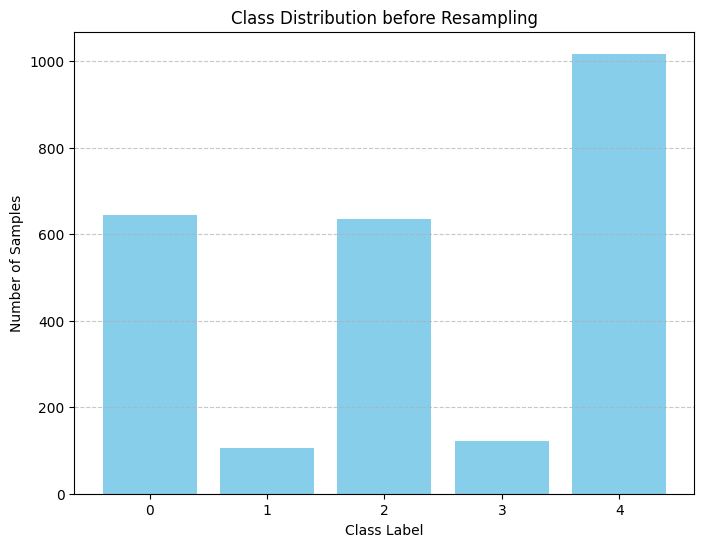

In [21]:
# Count the occurrences of each class label in y_train or y_train_balanced
class_counts = np.bincount(y_train) #if 'y_train' in globals() else np.bincount(y_train_balanced)

# Plot the class distribution
plt.figure(figsize=(8, 6))
plt.bar(range(len(class_counts)), class_counts, color='skyblue')
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Class Distribution before Resampling')
plt.xticks(range(len(class_counts)))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# **Add color channel dimension for grayscale images**

In [22]:
import numpy as np

# Reshape input data to add color channel dimension
X_train = np.expand_dims(X_train, axis=-1)  # Add color channel dimension for grayscale images

# Now, X_train_reshaped has a shape of (num_samples, height, width, 1)


# **Class Imbalance Mitigation: SMOTE Oversampling**

In [23]:
from imblearn.over_sampling import SMOTE
from keras.preprocessing.image import ImageDataGenerator

# Perform data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

# Fit the ImageDataGenerator on your data
datagen.fit(X_train)

# Reshape input data for SMOTE
x_train_reshaped = X_train.reshape(X_train.shape[0], -1)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
x_train_balanced, y_train_balanced = smote.fit_resample(x_train_reshaped, y_train)

# Reshape the balanced data back to the original shape
x_train_balanced = x_train_balanced.reshape(x_train_balanced.shape[0], 48, 48, 1)

# Update the generator to use balanced data
train_generator = datagen.flow(x_train_balanced, y_train_balanced, batch_size=batch_size)

# **Class Distribution After Resampling**

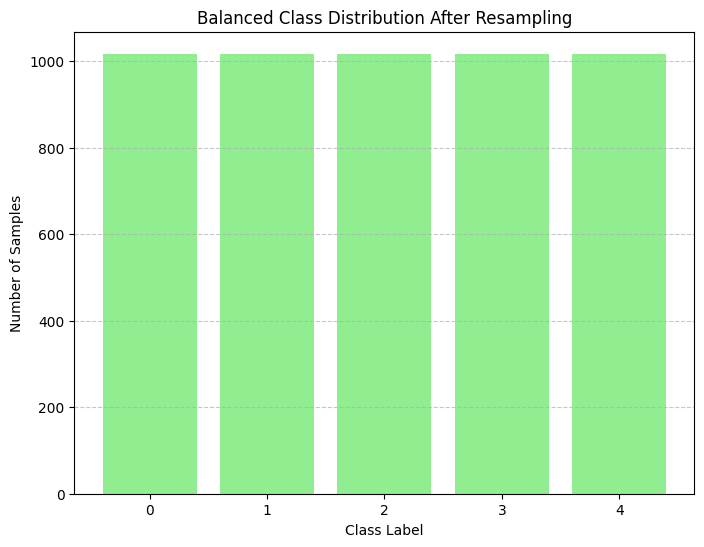

In [24]:
import matplotlib.pyplot as plt

# Count the occurrences of each class label in y_train_balanced
class_counts_balanced = np.bincount(y_train_balanced)

# Plot the balanced class distribution
plt.figure(figsize=(8, 6))
plt.bar(range(len(class_counts_balanced)), class_counts_balanced, color='lightgreen')
plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Balanced Class Distribution After Resampling')
plt.xticks(range(len(class_counts_balanced)))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# **Building Model with Convolutional Neural Network (CNN)**

In [25]:
y_train1=[]
for i in y_train_balanced:
    emotion = keras.utils.to_categorical(i, num_classes)
    print(i,emotion)
    y_train1.append(emotion)

y_train=y_train1
x_train_balanced = np.array(x_train_balanced, 'float32')
y_train = np.array(y_train, 'float32')
x_test = np.array(X_test, 'float32')
y_test = np.array(y_test, 'float32')

x_train_balanced /= 255  # normalize inputs between [0, 1]
x_test /= 255
print("x_train_balanced.shape",x_train_balanced.shape)
x_train_balanced = x_train_balanced.reshape(x_train_balanced.shape[0], 48, 48, 1)
x_train_balanced = x_train_balanced.astype('float32')
x_test = x_test.reshape(x_test.shape[0], 48, 48, 1)
x_test = x_test.astype('float32')

print(x_train_balanced.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
# ------------------------------
# construct CNN structure

model = Sequential()

# 1st convolution layer
model.add(Conv2D(64, (5, 5), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D(pool_size=(5, 5), strides=(2, 2)))

# 2nd convolution layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(AveragePooling2D(pool_size=(3, 3), strides=(2, 2)))

# 3rd convolution layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(AveragePooling2D(pool_size=(3, 3), strides=(2, 2)))

model.add(Flatten())

# fully connected neural networks
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(num_classes, activation='softmax'))
# ------------------------------
# batch process

print(x_train_balanced.shape)

gen = ImageDataGenerator()
train_generator = gen.flow(x_train_balanced, y_train, batch_size=batch_size)

# ------------------------------

model.compile(loss='categorical_crossentropy'
              , optimizer=keras.optimizers.Adam()
              , metrics=['accuracy']
              )

# ------------------------------
# Define the paths for model and history
model_path = "/content/drive/MyDrive/Object_DT/model1.h5"
history_path = "/content/drive/MyDrive/Object_DT/history1.pkl"


if not os.path.exists(model_path) or not os.path.exists(history_path):
    # Train the model and store history
    history = model.fit_generator(train_generator, steps_per_epoch=batch_size, epochs=epochs)
    model.save(model_path)  # Save the model
    with open(history_path, 'wb') as file:
        pickle.dump(history.history, file)  # Save the history object
else:
    # Load the model
    model = load_model(model_path)
    # Load the history
    with open(history_path, 'rb') as file:
        history = pickle.load(file)

# Predict probabilities for each class using the model
y_probabilities = model.predict(x_test)

# Convert probabilities to class labels
yp = np.argmax(y_probabilities, axis=-1)

cf=confusion_matrix(y_test,yp)

Streaming output truncated to the last 5000 lines.
2 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
4 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
4 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
4 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
4 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
4 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0 [1. 0. 0. 0. 0. 0. 

<ipython-input-25-2b0736f57652>:74: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=batch_size, epochs=epochs)


60/60 [==============================] - 35s 546ms/step - loss: 1.7279 - accuracy: 0.2025
Epoch 2/30
60/60 [==============================] - 32s 539ms/step - loss: 1.3985 - accuracy: 0.3782
Epoch 3/30
60/60 [==============================] - 31s 517ms/step - loss: 1.2724 - accuracy: 0.4399
Epoch 4/30
60/60 [==============================] - 34s 563ms/step - loss: 1.1700 - accuracy: 0.5063
Epoch 5/30
60/60 [==============================] - 31s 509ms/step - loss: 1.0832 - accuracy: 0.5644
Epoch 6/30
60/60 [==============================] - 31s 517ms/step - loss: 1.0258 - accuracy: 0.5916
Epoch 7/30
60/60 [==============================] - 31s 513ms/step - loss: 0.9403 - accuracy: 0.6324
Epoch 8/30
60/60 [==============================] - 30s 505ms/step - loss: 0.8537 - accuracy: 0.6639
Epoch 9/30
60/60 [==============================] - 32s 527ms/step - loss: 0.8036 - accuracy: 0.6851
Epoch 10/30
60/60 [==============================] - 29s 491ms/step - loss: 0.7368 - accuracy: 0.7174


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


79/79 [==============================] - 6s 77ms/step


# **Performance Analysis**

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test, yp)

# Calculate precision
precision = precision_score(y_test, yp, average='weighted')

# Calculate recall
recall = recall_score(y_test, yp, average='weighted')

# Calculate F1-score
f1 = f1_score(y_test, yp, average='weighted')

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Print classification report for detailed evaluation
print("\nClassification Report:")
print(classification_report(y_test, yp))


Accuracy: 0.7980198019801981
Precision: 0.7918485651175401
Recall: 0.7980198019801981
F1-score: 0.7931848472368288

Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.85      0.84       652
         1.0       0.37      0.30      0.33       113
         2.0       0.86      0.87      0.86       617
         3.0       0.68      0.44      0.53       143
         4.0       0.79      0.82      0.81      1000

    accuracy                           0.80      2525
   macro avg       0.70      0.66      0.68      2525
weighted avg       0.79      0.80      0.79      2525



# **Plotting Training Loss and Accuracy over Epochs**

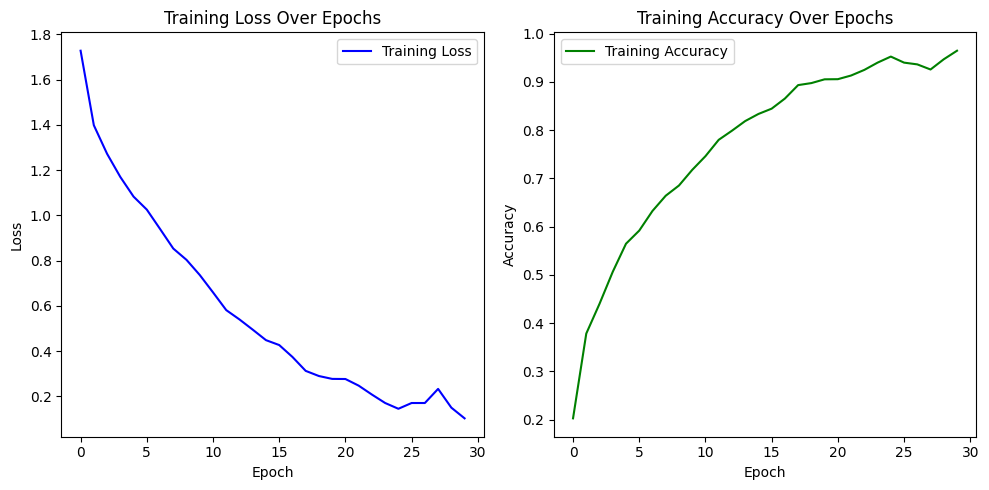

In [27]:
# Plot training loss and accuracy over epochs
plt.figure(figsize=(10, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


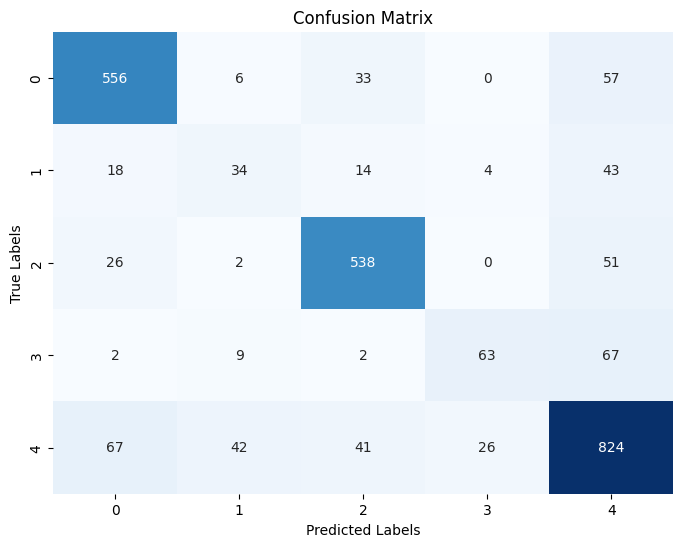

In [28]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, yp)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# **Prediction for a Specific Teeth**

In [29]:
def prepare_data(path):
    data_list = []

    file_path = os.path.join(path)
    print(file_path)
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
      res = cv2.resize(img, (48, 48), interpolation=cv2.INTER_CUBIC)
      data_list.append(res)
    else:
      print("Error: Input image is empty!")
    return (np.asarray(data_list, dtype=np.float32))

In [30]:
from keras import backend as K
def predict_teeth(image_path):
    K.clear_session()

    dataset=prepare_data(image_path)
    (mnist_row, mnist_col, mnist_color) = 48, 48, 1

    dataset = dataset.reshape(dataset.shape[0], mnist_row, mnist_col, mnist_color)
    mo = load_model("/content/drive/MyDrive/Object_DT/model1.h5")
    dataset /= 255

    # Predict probabilities for each class using the model
    y_probabilities = model.predict(dataset)

    # Convert probabilities to class labels
    yp = np.argmax(y_probabilities, axis=-1)

    K.clear_session()

    return yp[0]

In [39]:
# Choose the path for prediction
image_path="/content/drive/MyDrive/Object_DT/test/test2.jpg"

predicted_resut = predict_teeth(image_path)
output = ""

if predicted_resut == 0:
  output = "Predicted result is Calculus"
elif predicted_resut == 1:
  output = "Predicted result is caries"
elif predicted_resut == 2:
  output = "Predicted result is hypodontia"
elif predicted_resut == 3:
  output = "Predicted result is Mouth Ulcer"
elif predicted_resut == 4:
  output = "Predicted result is Tooth Discoloration"

# print(predicted_resut)
output

/content/drive/MyDrive/Object_DT/test/test2.jpg
1/1 [==============================] - 0s 117ms/step


'Predicted result is hypodontia'